<a href="https://colab.research.google.com/github/Se0mjun/Applications/blob/main/LSTM_with_weather_forecasting_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl https://www.bgc-jena.mpg.de/wetter/mpi_saale_2021b.zip -o mpi_saale_2021b.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1486k  100 1486k    0     0   484k      0  0:00:03  0:00:03 --:--:--  485k


In [ ]:
# time series data 시계열 데이터 전처리
import zipfile
import pandas

zip_file = zipfile.ZipFile("mpi_saale_2021b.zip")
zip_file.extractall()
csv_path = "mpi_saale_2021b.csv"
data_frame = pandas.read_csv(csv_path)


print (data_frame)
# 6 months , per 10 min

                 Date Time  p (mbar)  T (degC)  rh (%)  sh (g/kg)  Tpot (K)  \
0      01.07.2021 00:10:00    994.66     15.30   88.00       9.64    288.89   
1      01.07.2021 00:20:00    994.60     15.16   89.90       9.76    288.76   
2      01.07.2021 00:30:00    994.56     15.18   90.90       9.88    288.78   
3      01.07.2021 00:40:00    994.55     15.73   86.70       9.76    289.33   
4      01.07.2021 00:50:00    994.58     16.18   84.30       9.77    289.78   
...                    ...       ...       ...     ...        ...       ...   
26491  31.12.2021 23:20:00   1004.48     13.53   79.01       7.63    286.31   
26492  31.12.2021 23:30:00   1004.54     13.49   79.09       7.62    286.27   
26493  31.12.2021 23:40:00   1004.53     13.52   78.68       7.59    286.30   
26494  31.12.2021 23:50:00   1004.62     13.55   78.32       7.57    286.32   
26495  01.01.2022 00:00:00   1004.68     13.52   78.39       7.56    286.29   

       Tdew (degC)  VPmax (mbar)  VPact (mbar)  VPd

In [ ]:
# 전처리 ( wind_speed 이상치 제거 )
data_frame = data_frame[(data_frame['wv (m/s)'] >= 0) & (data_frame['wv (m/s)'] <= 40)] # 바람 세기가 0에서 40이라 기대할때의 전처리

In [ ]:
# 변수 (variables) 할당
time = data_frame['Date Time']
temperature = data_frame['T (degC)']
pressure = data_frame['p (mbar)']
relative_humidity = data_frame['rh (%)']
vapor_pressure = data_frame['VPact (mbar)']
wind_speed = data_frame['wv (m/s)']
airtight = data_frame['rho (g/m**3)']

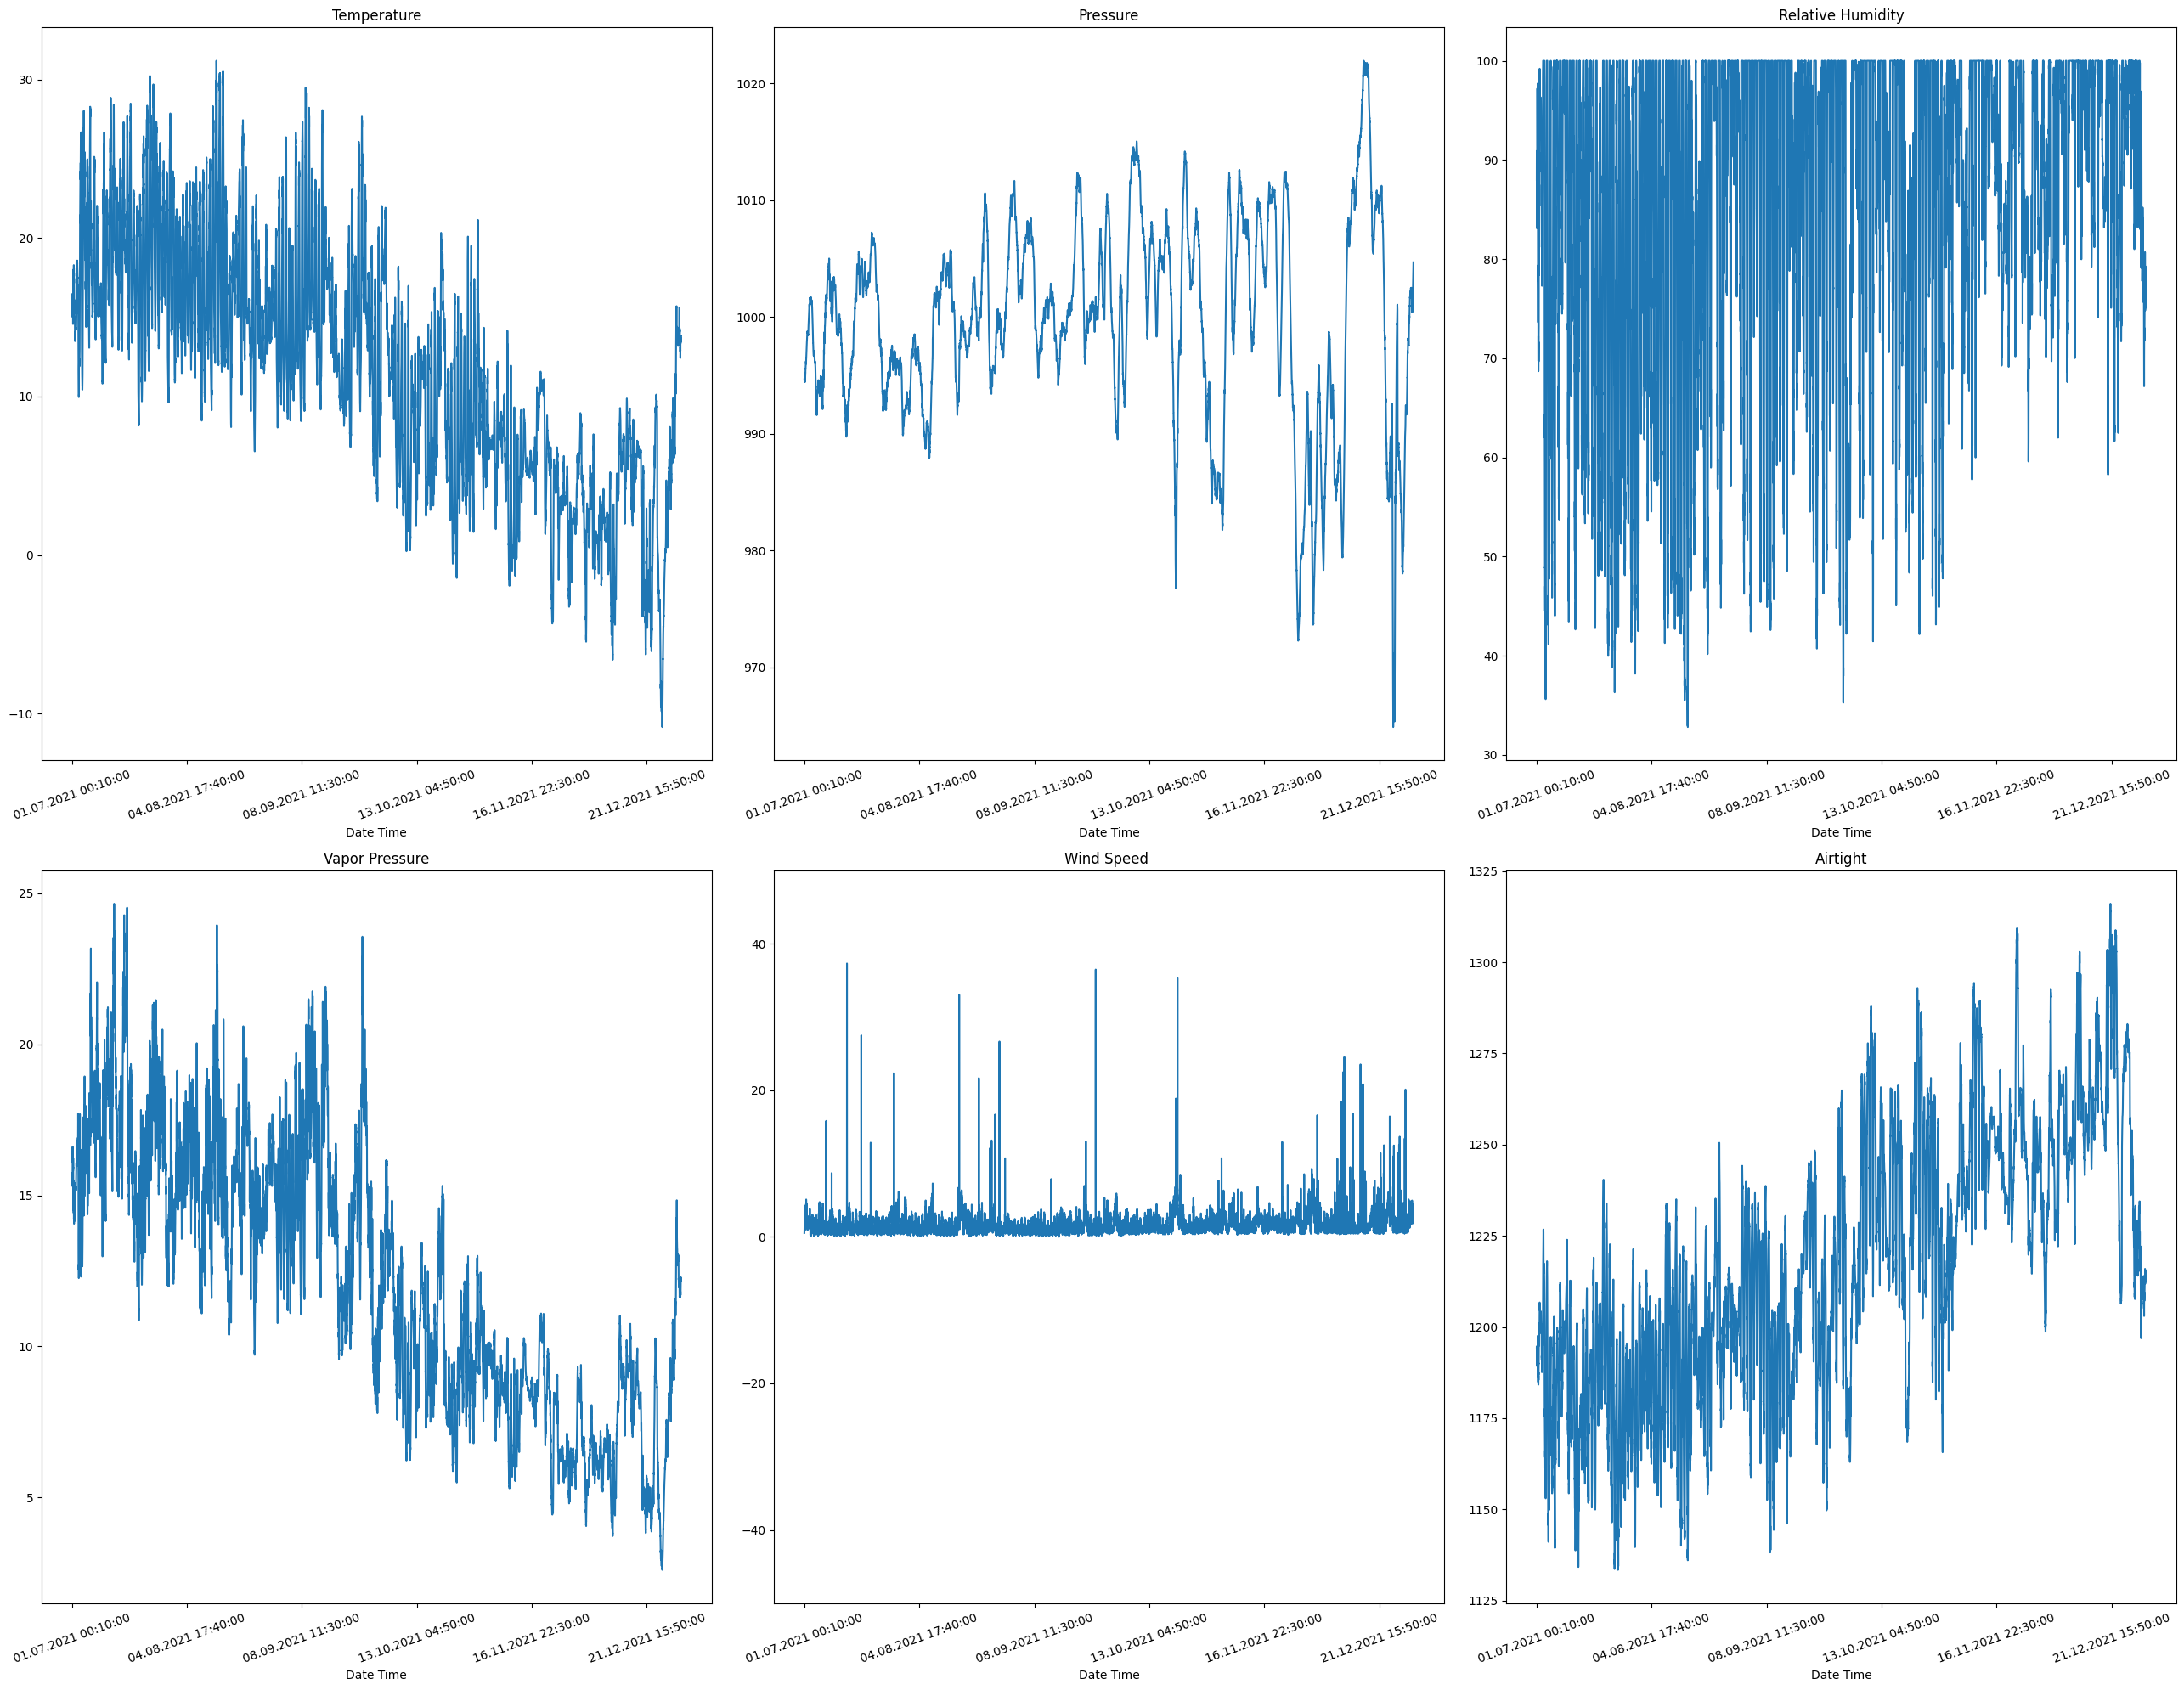

In [ ]:
# 6개의 기상 데이터를 시간 경과에 따른 그래프 시각화 (graph )
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.subplots(nrows=2, ncols=3, figsize=(26, 20))

ax = plt.subplot(2, 3, 1)
temperature.index = time
temperature.head()
temperature.plot(rot=20)
plt.title('Temperature')

ax = plt.subplot(2, 3, 2)
pressure.index = time
pressure.head()
pressure.plot(rot=20)
plt.title('Pressure')

ax = plt.subplot(2, 3, 3)
relative_humidity.index = time
relative_humidity.head()
relative_humidity.plot(rot=20)
plt.title('Relative Humidity')

ax = plt.subplot(2, 3, 4)
vapor_pressure.index = time
vapor_pressure.head()
vapor_pressure.plot(rot=20)
plt.title('Vapor Pressure')

ax = plt.subplot(2, 3, 5)
wind_speed.index = time
wind_speed.head()
wind_speed.plot(rot=20)
plt.ylim(-50, 50)
plt.title('Wind Speed ')

ax = plt.subplot(2, 3, 6)
airtight.index = time
airtight.head()
airtight.plot(rot=20)
plt.title('Airtight')

plt.tight_layout()
plt.show()

In [ ]:
# Data 전처리 Processing : Data Sampling , Data normalization
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [ ]:

features = pandas.concat([temperature, pressure, relative_humidity, vapor_pressure, wind_speed, airtight], axis=1)
features.index = time
features

,T (degC),p (mbar),rh (%),VPact (mbar),wv (m/s),rho (g/m**3)
Date Time,,,,,,
01.07.2021 00:10:00,15.30,994.66,88.00,15.32,0.52,1194.25
01.07.2021 00:20:00,15.16,994.60,89.90,15.51,0.56,1194.67
01.07.2021 00:30:00,15.18,994.56,90.90,15.71,1.09,1194.45
01.07.2021 00:40:00,15.73,994.55,86.70,15.52,1.09,1192.25
01.07.2021 00:50:00,16.18,994.58,84.30,15.53,1.28,1190.43
...,...,...,...,...,...,...
31.12.2021 23:20:00,13.53,1004.48,79.01,12.27,3.03,1214.96
31.12.2021 23:30:00,13.49,1004.54,79.09,12.25,3.22,1215.21
31.12.2021 23:40:00,13.52,1004.53,78.68,12.21,3.59,1215.09


In [ ]:
# Data 전처리 Processing
features = normalize(features.values)
features = pandas.DataFrame(features)
features
# Normalization

,0,1,2,3,4,5
0,0.503946,-0.586328,0.136258,0.737388,-0.761302,-0.687739
1,0.485369,-0.593300,0.252858,0.780803,-0.732108,-0.675953
2,0.488023,-0.597948,0.314226,0.826503,-0.345295,-0.682127
3,0.561006,-0.599110,0.056479,0.783088,-0.345295,-0.743866
4,0.620719,-0.595624,-0.090805,0.785373,-0.206627,-0.794941
...,...,...,...,...,...,...
26485,0.269074,0.554759,-0.415444,0.040462,1.070586,-0.106551
26486,0.263766,0.561731,-0.410534,0.035892,1.209255,-0.099535
26487,0.267747,0.560569,-0.435695,0.026752,1.479294,-0.102903
26488,0.271728,0.571027,-0.457788,0.019897,1.442802,-0.102903


In [ ]:
# Data 전처리 Processing : Data array after normalization ( 80 % Training , 20 % Vaildation) : general method
training_size = int ( 0.8 * features.shape[0])
train_data = features.loc[0 : training_size - 1]
val_data = features.loc[training_size:]

In [ ]:
# Data 전처리 Processing : Training dataset
start = 432 + 36 # timestamps : 432(Data), 36(Prediction)
end = start + training_size

x_train = train_data.values # input
y_train = features.iloc[start:end][[0]] # target

sequence_length = int(432 / 6) # sequence 길이 설정

In [ ]:
# Data 전처리 Processing : Tensorflow dataset
from tensorflow import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

In [ ]:
# Data 전처리 Processing : Validation dataset setting
x_val_end = len(val_data) - start

label_start = training_size + start

x_val = val_data.iloc[:x_val_end][[i for i in range(6)]].values
y_val = features.iloc[label_start:][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

In [ ]:
# Creating LSTM Model
for batch in dataset_train.take(1):
    inputs, targets = batch

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "Weather_forcaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 72, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,025 (19.63 KB)

 Trainable params: 5,025 (19.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training
history = model.fit(
    dataset_train,
    epochs=15,
    validation_data=dataset_val
)

Epoch 1/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 0.6424 - val_loss: 0.4894
Epoch 2/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.2531 - val_loss: 0.4878
Epoch 3/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.1883 - val_loss: 0.4271
Epoch 4/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.1741 - val_loss: 0.3988
Epoch 5/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.1644 - val_loss: 0.3743
Epoch 6/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.1562 - val_loss: 0.3571
Epoch 7/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.1482 - val_loss: 0.3446
Epoch 8/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.1406 - val_loss: 0.3357
Epoch 9/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.1341 - val_loss: 0.3321
Epoch 10/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.1283 - val_loss: 0.3318
Epoch 11/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.1230 - val_loss: 0.3375
Epoch 12/15
325/325 ━━━━━━━━━━

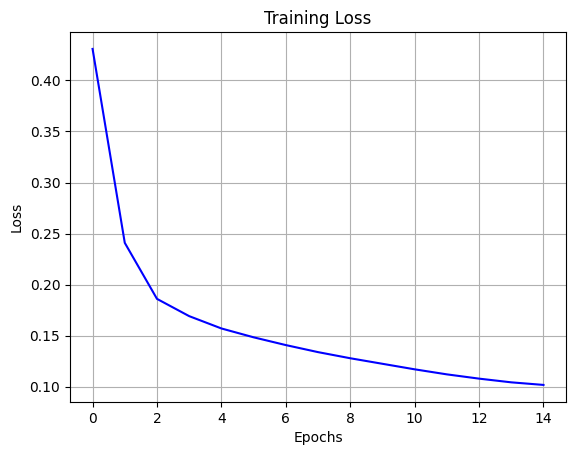

In [ ]:
# Results of fitting the model in terms of training loss
loss = history.history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid("Ture")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


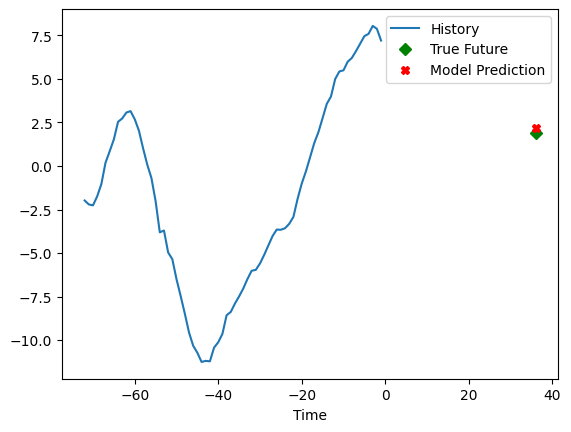

In [ ]:
# Result of predicting the normalized temperature for a value in the validation dataset.
temp_mean = temperature.mean(axis=0)
temp_std = temperature.std(axis=0)

for x, y in dataset_val.skip(12):
    history_data = x[0][:, 1].numpy() * temp_std + temp_mean
    true_value = y[0].numpy() * temp_std + temp_mean
    prediction = model.predict(x)[0] * temp_std + temp_mean
    time_steps = list(range(-(history_data.shape[0]), 0))
    plt.plot(time_steps, history_data)
    plt.plot(36, true_value, "gD")
    plt.plot(36, prediction, "rX")
    plt.legend(["History", "True Future", "Model Prediction"])
    plt.xlabel("Time")
    plt.show()
    break